# Imports de llibreries

In [65]:
import pandas as pd
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim import corpora
import warnings
import os
nltk.download('stopwords')
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

[nltk_data] Downloading package stopwords to /home/beri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Càrrega del dataset

In [15]:
df_proposals = pd.read_csv("../data/processed/processed_barcelona_proposals.csv")

# Implementació del BERTopic

In [16]:
stop_words = nltk.corpus.stopwords.words('catalan')

In [25]:
cluster_model = KMeans(n_clusters=15)
vectorizer_model = CountVectorizer(stop_words=list(stop_words))
topic_model = BERTopic(language="catalan",  vectorizer_model=vectorizer_model, hdbscan_model=cluster_model, top_n_words=5)
topics, probs = topic_model.fit_transform(df_proposals['description/ca'])
topic_model.get_document_info(df_proposals['description/ca'])

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Representative_document
0,\nExecutar una bateria de mesures que situïn l...,1,1_eficients_electrodomèstics_vida_plaques,"[eficients, electrodomèstics, vida, plaques, e...",[\nAllargar el cicle de vida i assegurar el re...,eficients - electrodomèstics - vida - plaques ...,True
1,\nCrear un únic punt administratiu per gestion...,0,0_comunitats_energètiques_tràmits_veïnals,"[comunitats, energètiques, tràmits, veïnals, t...",[\nConstruir estructures emblemàtiques amb val...,comunitats - energètiques - tràmits - veïnals ...,True
2,\nDonar a conèixer les comunitats energètiques...,0,0_comunitats_energètiques_tràmits_veïnals,"[comunitats, energètiques, tràmits, veïnals, t...",[\nConstruir estructures emblemàtiques amb val...,comunitats - energètiques - tràmits - veïnals ...,True
3,\nCrear la normativa necessària per regular i ...,0,0_comunitats_energètiques_tràmits_veïnals,"[comunitats, energètiques, tràmits, veïnals, t...",[\nConstruir estructures emblemàtiques amb val...,comunitats - energètiques - tràmits - veïnals ...,False
4,\nConstruir estructures emblemàtiques amb valo...,0,0_comunitats_energètiques_tràmits_veïnals,"[comunitats, energètiques, tràmits, veïnals, t...",[\nConstruir estructures emblemàtiques amb val...,comunitats - energètiques - tràmits - veïnals ...,True
5,\nNou sistema tarifari de l’electricitat per f...,2,2_energètic_consum_reducció_criteris,"[energètic, consum, reducció, criteris, energè...",[\nLimitar el preu del lloguer segons les cond...,energètic - consum - reducció - criteris - ene...,True
6,\nCrear un hub o pol d’empreses especialitzade...,13,13_tecnologies_energètic_redueixin_pol,"[tecnologies, energètic, redueixin, pol, manera]",[\nCrear un hub o pol d’empreses especialitzad...,tecnologies - energètic - redueixin - pol - ma...,True
7,\nIncentivar econòmicament la substitució d’el...,1,1_eficients_electrodomèstics_vida_plaques,"[eficients, electrodomèstics, vida, plaques, e...",[\nAllargar el cicle de vida i assegurar el re...,eficients - electrodomèstics - vida - plaques ...,True
8,\nAllargar el cicle de vida i assegurar el rec...,1,1_eficients_electrodomèstics_vida_plaques,"[eficients, electrodomèstics, vida, plaques, e...",[\nAllargar el cicle de vida i assegurar el re...,eficients - electrodomèstics - vida - plaques ...,True
9,\nLimitar el preu del lloguer segons les condi...,2,2_energètic_consum_reducció_criteris,"[energètic, consum, reducció, criteris, energè...",[\nLimitar el preu del lloguer segons les cond...,energètic - consum - reducció - criteris - ene...,True


Seguint amb els 15 clústers de tòpics tal i com havíem fet al modelatge anterior amb BERTopic de les dades de l'Assemblea Ciutadana pel Clima de Catalunya, ho fem també amb el dataset de l'Ajuntament de Barcelona.

In [42]:
topic_list = topic_model.get_document_info(df_proposals['description/ca'])['Top_n_words']
df_proposals['topics'] = topic_list
df_proposals.head(6)

,id,category/name/ca,category/name/es,title/ca,body/ca,state,answer/ca,answer/es,supports,endorsements/total_count,...,is_amend,title/es,body/es,description/ca,justification/ca,actions/ca,description/es,justification/es,actions/es,topics
0,38115,Energia,Energía,Reduir el consum energètic de l'Ajuntament,Descripció:\nExecutar una bateria de mesures q...,accepted,Aquesta proposta és viable i està alineada amb...,Esta propuesta es viable y está alineada con a...,0,0,...,False,Reducir el consumo energético del Ayuntamiento,Descripción:\nEjecutar una batería de medidas ...,\nExecutar una bateria de mesures que situïn l...,\nL'Ajuntament té marge per actuar en els edif...,\n\n* Repensar la il·luminació de la ciutat pe...,\nEjecutar una batería de medidas que sitúen a...,\nEl Ayuntamiento tiene margen para actuar en ...,\n\n* Repensar la iluminación de la ciudad par...,eficients - electrodomèstics - vida - plaques ...
1,38116,Energia,Energía,Facilitar els tràmits de la transició energètica,Descripció:\nCrear un únic punt administratiu ...,accepted,Aquesta proposta és viable i està alineada amb...,Esta propuesta es viable y está alineada con a...,0,0,...,False,Facilitar los trámites de la transición energé...,Descripción:\nCrear un único punto administrat...,\nCrear un únic punt administratiu per gestion...,\nFacilitar els tràmits administratius pot imp...,\n\n* Crear una finestreta única de cara a la ...,\nCrear un único punto administrativo para ges...,\nFacilitar los trámites administrativos puede...,\n\n* Crear una ventanilla única de cara a la ...,comunitats - energètiques - tràmits - veïnals ...
2,38117,Energia,Energía,Difondre les Comunitats Energètiques a través ...,Descripció:\nDonar a conèixer les comunitats e...,accepted,Aquesta proposta és viable i està alineada amb...,Esta propuesta es viable y está alineada con a...,0,0,...,False,Difundir las Comunidades Energéticas a través ...,Descripción:\nDar a conocer las comunidades en...,\nDonar a conèixer les comunitats energètiques...,\nLes comunitats energètiques són una eina cla...,.,\nDar a conocer las comunidades energéticas a ...,\nLas comunidades energéticas son una herramie...,\n\n* Organizar reuniones con las asociaciones...,comunitats - energètiques - tràmits - veïnals ...
3,38118,Energia,Energía,Crear la normativa necessària per impulsar les...,Descripció:\nCrear la normativa necessària per...,accepted,Aquesta proposta és viable i està alineada amb...,Esta propuesta es viable y está alineada con a...,0,0,...,False,Crear la normativa necesaria para impulsar las...,Descripción:\nCrear la normativa necesaria par...,\nCrear la normativa necessària per regular i ...,\nLes comunitats energètiques impliquen l’auto...,"\n\n* Desenvolupar la normativa necessària i, ...",\nCrear la normativa necesaria para regular y ...,\nLas comunidades energéticas implican la auto...,"\n\n* Desarrollar la normativa necesaria y, en...",comunitats - energètiques - tràmits - veïnals ...
4,38119,Energia,Energía,Generar cultura i sensibilització entorn de la...,Descripció:\nConstruir estructures emblemàtiqu...,accepted,Aquesta proposta és viable i està alineada amb...,Esta propuesta es viable y está alineada con a...,0,0,...,False,Generar cultura y sensiblización en torno a la...,Descripción:\nConstruir estructuras emblemátic...,\nConstruir estructures emblemàtiques amb valo...,\nLa sensibilització de la ciutadania és neces...,\n\n* Aprofitar els grans esdeveniments de ciu...,\nConstruir estructuras emblemáticas con valor...,\nLa sensibilización de la ciudadanía es neces...,\n\n* Aprovechar los grandes acontecimientos d...,comunitats - energètiques - tràmits - veïnals ...
5,38120,Energia,Energía,Garantir un consum energètic mínim vital i des...,Descripció:\nNou sistema tarifari de l’electri...,accepted,Aquesta proposta és parcialment viable i està ...,Esta propuesta es en parte viable y está aline...,0,0,...,False,Garantizar un consumo energético mínimo vital ...,Descripción:\nNuevo sistema tarifar

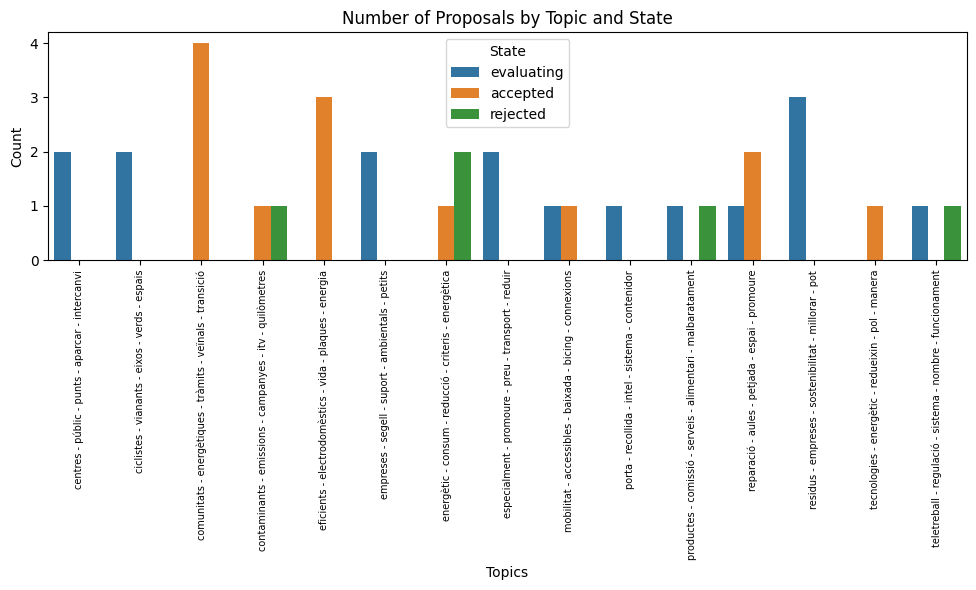

In [61]:
grouped = df_proposals.groupby(['topics', 'state']).size().reset_index(name='count')

plt.figure(figsize=(10, 6))
sns.barplot(data=grouped, x='topics', y='count', hue='state')
plt.xticks(rotation=90, fontsize=7)
plt.xlabel('Topics')
plt.ylabel('Count')
plt.title('Number of Proposals by Topic and State')
plt.legend(title='State')
plt.tight_layout()
plt.show()

## Coherència del model

In [69]:
def calculate_bertopic_coherence(topic_model, docs):
    cleaned_docs = topic_model._preprocess_text(docs)
    vectorizer = topic_model.vectorizer_model
    analyzer = vectorizer.build_analyzer()
    tokens = [analyzer(doc) for doc in cleaned_docs]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    topics = topic_model.get_topics()
    topics.pop(-1, None)
    topic_words = [
        [word for word, _ in topic_model.get_topic(topic) if word != ""] for topic in topics
    ]
    topic_words = [[words for words, _ in topic_model.get_topic(topic)] for topic in range(len(set(topics))-1)]

    coherence_model = CoherenceModel(topics=topic_words, 
                                texts=tokens, 
                                corpus=corpus,
                                dictionary=dictionary, 
                                coherence='c_v')
    coherence = coherence_model.get_coherence()
    print(f"Coherència del model BERTopic: {coherence}")

calculate_bertopic_coherence(topic_model, df_proposals['description/ca'])

Coherència del model BERTopic: 0.5902918359240353
